# Libraries and Dataset load

In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import sklearn.compose
from scipy import stats
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso
import seaborn as sns

Se cargan los datos de entrenamiento y los necesarios para hacer la predicción desde un repositorio online. Los datos de entrenamiento se mezclan de forma aleatoria.

In [ ]:
data_train = pd.read_csv("https://raw.githubusercontent.com/bipbopbup/ML/main/train.csv", sep=",")
data_train = data_train.sample(frac=1, random_state=43).reset_index(drop=True)

data_test = pd.read_csv("https://raw.githubusercontent.com/bipbopbup/ML/main/test.csv", sep=",")

y = data_train['charges']
data_train.drop(columns='charges', inplace=True)

data_train

,id,age,sex,bmi,children,smoker,region
0,720,51,female,40.660,0,no,northeast
1,82,22,male,37.620,1,yes,southeast
2,80,31,male,26.885,1,no,northeast
3,851,61,male,32.300,2,no,northwest
4,307,30,female,33.330,1,no,southeast
...,...,...,...,...,...,...,...
931,1152,43,female,32.560,3,yes,southeast
932,544,54,male,30.210,0,no,northwest
933,482,18,female,31.350,0,no,southeast
934,689,27,male,31.130,1,yes,southeast


# Initial study


Se describen los datos correspondientes a cada columna.


In [ ]:
data_train.describe(include="all")

,id,age,sex,bmi,children,smoker,region
count,936.000000,936.000000,936,936.000000,936.000000,936,936
unique,NaN,NaN,2,NaN,NaN,2,4
top,NaN,NaN,male,NaN,NaN,no,southeast
freq,NaN,NaN,481,NaN,NaN,733,251
mean,670.162393,39.201923,NaN,30.483323,1.092949,NaN,NaN
std,385.864903,13.978319,NaN,5.998443,1.194870,NaN,NaN
min,0.000000,18.000000,NaN,16.815000,0.000000,NaN,NaN
25%,333.750000,27.000000,NaN,26.125000,0.000000,NaN,NaN
50%,673.500000,39.000000,NaN,30.250000,1.000000,NaN,NaN
75%,1007.500000,51.000000,NaN,34.210000,2.000000,NaN,NaN


Se aplican los test de Kolmogorov-Smirnov.

In [ ]:
for x in data_train.columns:
  try:
    print()
    print(x)
    print("  Normal: ",stats.kstest(data_train[x], 'norm'))
    print("  Uniforme: ",stats.kstest(data_train[x], 'uniform'))
    print("  Exponencial: ",stats.kstest(data_train[x], 'expon'))
  except:
    pass


id
  Normal:  KstestResult(statistic=0.9967632005530387, pvalue=0.0)
  Uniforme:  KstestResult(statistic=0.9989316239316239, pvalue=0.0)
  Exponencial:  KstestResult(statistic=0.9937462376925652, pvalue=0.0)

age
  Normal:  KstestResult(statistic=1.0, pvalue=0.0)
  Uniforme:  KstestResult(statistic=1.0, pvalue=0.0)
  Exponencial:  KstestResult(statistic=0.9999999847700203, pvalue=0.0)

sex

bmi
  Normal:  KstestResult(statistic=1.0, pvalue=0.0)
  Uniforme:  KstestResult(statistic=1.0, pvalue=0.0)
  Exponencial:  KstestResult(statistic=0.999999950187506, pvalue=0.0)

children
  Normal:  KstestResult(statistic=0.5, pvalue=6.641902247327977e-217)
  Uniforme:  KstestResult(statistic=0.5683760683760684, pvalue=2.815254151550967e-286)
  Exponencial:  KstestResult(statistic=0.43162393162393164, pvalue=5.733436293576294e-159)

smoker

region


Se estudian las posibles relaciones entre columnas.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20ccb71190>,
      dtype=object)

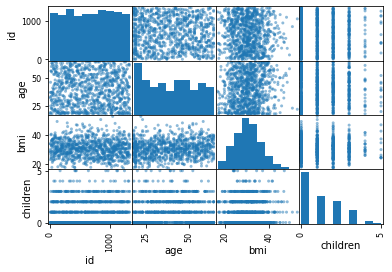

In [ ]:
pd.plotting.scatter_matrix(data_train)

Se dibuja la matriz de correlacción entre variables.

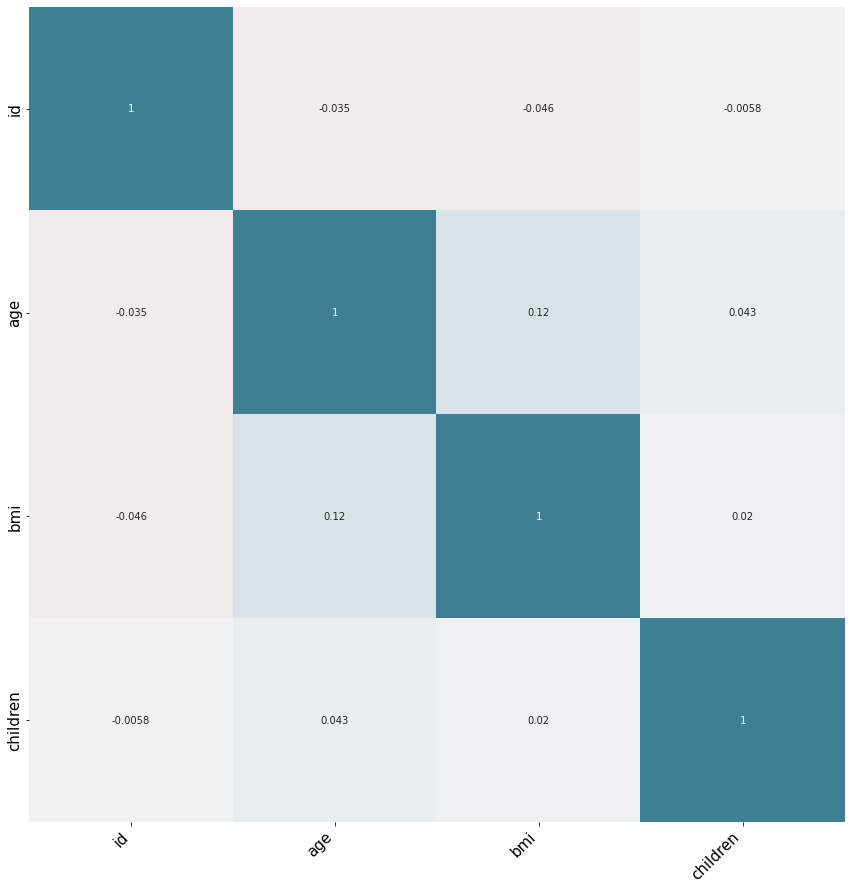

In [ ]:
def dibujarMatrizCorrelacion(X):
  matrizCorrelacion = X.corr(method='pearson')

  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15))

  sns.heatmap(
      matrizCorrelacion,
      annot     = True,
      cbar      = False,
      annot_kws = {"size": 10},
      vmin      = -1,
      vmax      = 1,
      center    = 0,
      cmap      = sns.diverging_palette(20, 220, n=200),
      square    = True,
      ax        = ax
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation = 45,
      horizontalalignment = 'right',
  )

  ax.tick_params(labelsize = 15)

dibujarMatrizCorrelacion(data_train)

# Preprocessing


La columna del bmi (índice de masa corporal) se ha discretizado, sustituyendo los valores menores de 30 por normal y el resto por sobrepeso.

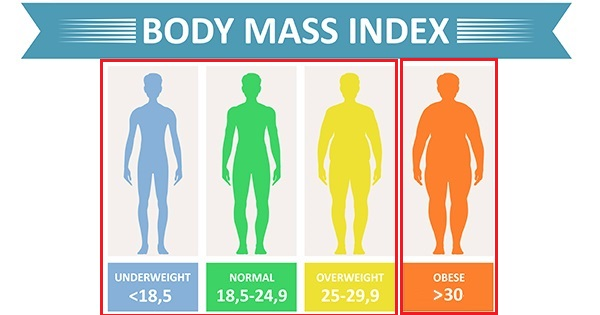

In [ ]:
limites = [0, 30, 1000]
nombres = ['normal', 'overweight']
data_train['bmi'] = pd.cut(data_train['bmi'], limites, labels = nombres)
data_test['bmi'] = pd.cut(data_test['bmi'], limites, labels = nombres)
data_train

,id,age,sex,bmi,children,smoker,region
0,720,51,female,overweight,0,no,northeast
1,82,22,male,overweight,1,yes,southeast
2,80,31,male,normal,1,no,northeast
3,851,61,male,overweight,2,no,northwest
4,307,30,female,overweight,1,no,southeast
...,...,...,...,...,...,...,...
931,1152,43,female,overweight,3,yes,southeast
932,544,54,male,overweight,0,no,northwest
933,482,18,female,overweight,0,no,southeast
934,689,27,male,overweight,1,yes,southeast


Se eleva al cubo el valor de age para aumentar la diferencia entre sus valores.

In [ ]:
def ageAlCubo(row):
  return row.age**3

data_train['age'] = data_train.apply(ageAlCubo, axis=1)
data_test['age'] = data_test.apply(ageAlCubo, axis=1)

data_train

,id,age,sex,bmi,children,smoker,region
0,720,132651,female,overweight,0,no,northeast
1,82,10648,male,overweight,1,yes,southeast
2,80,29791,male,normal,1,no,northeast
3,851,226981,male,overweight,2,no,northwest
4,307,27000,female,overweight,1,no,southeast
...,...,...,...,...,...,...,...
931,1152,79507,female,overweight,3,yes,southeast
932,544,157464,male,overweight,0,no,northwest
933,482,5832,female,overweight,0,no,southeast
934,689,19683,male,overweight,1,yes,southeast


Se añade una nueva columna formada por la combinación de los valores del bmi, si tiene hijos o no, y si es fumador o no.

Mediante las pruebas se ha determinado que el tener o no hijos, el bmi y ser o no fumador son las variables más influyentes y al combinarlas en una sola columna se les da un peso mayor.

In [ ]:
def bmi_children_smoker(row):
  result = row.bmi
  if(row.children==0):
    result+='-nochildren-'
  else:
    result+='-children-'
  if(row.smoker=='no'):
    return result+'nonsmoker'
  else:
    return result+'smoker'

data_train['bmi-children-smoker'] = data_train.apply(bmi_children_smoker, axis=1)
data_test['bmi-children-smoker'] = data_test.apply(bmi_children_smoker, axis=1)

data_train

,id,age,sex,bmi,children,smoker,region,bmi-children-smoker
0,720,132651,female,overweight,0,no,northeast,overweight-nochildren-nonsmoker
1,82,10648,male,overweight,1,yes,southeast,overweight-children-smoker
2,80,29791,male,normal,1,no,northeast,normal-children-nonsmoker
3,851,226981,male,overweight,2,no,northwest,overweight-children-nonsmoker
4,307,27000,female,overweight,1,no,southeast,overweight-children-nonsmoker
...,...,...,...,...,...,...,...,...
931,1152,79507,female,overweight,3,yes,southeast,overweight-children-smoker
932,544,157464,male,overweight,0,no,northwest,overweight-nochildren-nonsmoker
933,482,5832,female,overweight,0,no,southeast,overweight-nochildren-nonsmoker
934,689,19683,male,overweight,1,yes,southeast,overweight-children-smoker


Se realiza el preprocesamiento de las columnas discretas que venían en los datos iniciales, así como la eliminación del id y de los datos que se consideran duplicados (bmi, smoker y children) por haber añadido la columna extra.

Se elimina la columna de region dado que tras las pruebas se concluyó que su infuencia solo añadía ruido al modelo final.

El resto de columnas aún no sufren ningún tratamiento.

In [ ]:
column_transformer_discreto = sklearn.compose.ColumnTransformer(transformers=[
    ("drop", "drop", ['id', 'bmi','smoker', 'children', 'region']),
    ("one-hot", sklearn.preprocessing.OneHotEncoder(), ['sex']),
], remainder = 'passthrough');

columns1 = ['female', 'male', 'age', 'bmi-children-smoker']

X = pd.DataFrame(column_transformer_discreto.fit_transform(data_train), columns=columns1)

X

,female,male,age,bmi-children-smoker
0,1,0,132651,overweight-nochildren-nonsmoker
1,0,1,10648,overweight-children-smoker
2,0,1,29791,normal-children-nonsmoker
3,0,1,226981,overweight-children-nonsmoker
4,1,0,27000,overweight-children-nonsmoker
...,...,...,...,...
931,1,0,79507,overweight-children-smoker
932,0,1,157464,overweight-nochildren-nonsmoker
933,1,0,5832,overweight-nochildren-nonsmoker
934,0,1,19683,overweight-children-smoker


Se realiza el preprocesamiento de la columna discreta formada por la combinación de bmi, children y smoker, creando tantas columnas como sus posibles valores (8).

Además a la columna edad se le aplica estandarización.

In [ ]:
column_transformer_continuo = sklearn.compose.ColumnTransformer(transformers=[
    ("scale", sklearn.preprocessing.StandardScaler(), ['age']),
    ("one-hot", sklearn.preprocessing.OneHotEncoder(), ['bmi-children-smoker'])
], remainder = 'passthrough');

columns2 = ['age', 'normal-children-nonsmoker', 'normal-children-smoker', 'normal-nochildren-nonsmoker', 'normal-nochildren-smoker',
            'overweight-children-nonsmoker', 'overweight-children-smoker', 'overweight-nochildren-nonsmoker', 'overweight-nochildren-smoker', 'female', 'male']

X = pd.DataFrame(column_transformer_continuo.fit_transform(X), columns=columns2)

X

,age,normal-children-nonsmoker,normal-children-smoker,normal-nochildren-nonsmoker,normal-nochildren-smoker,overweight-children-nonsmoker,overweight-children-smoker,overweight-nochildren-nonsmoker,overweight-nochildren-smoker,female,male
0,0.667259,0,0,0,0,0,0,1,0,1,0
1,-0.985583,0,0,0,0,0,1,0,0,0,1
2,-0.726242,1,0,0,0,0,0,0,0,0,1
3,1.9452,0,0,0,0,1,0,0,0,0,1
4,-0.764054,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
931,-0.0527124,0,0,0,0,0,1,0,0,1,0
932,1.00341,0,0,0,0,0,0,1,0,0,1
933,-1.05083,0,0,0,0,0,0,1,0,1,0
934,-0.863181,0,0,0,0,0,1,0,0,0,1


Se representan los datos tras el preprocesamiento.

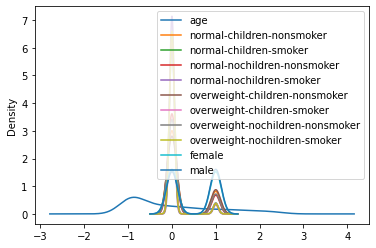

In [ ]:
X.plot.kde()

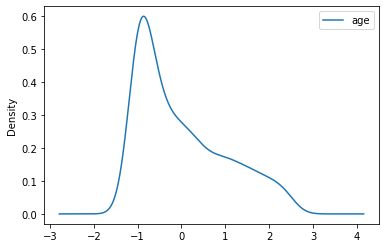

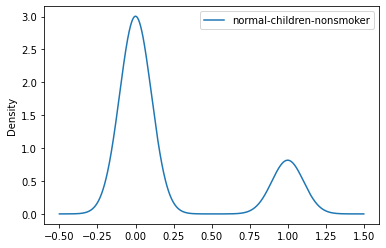

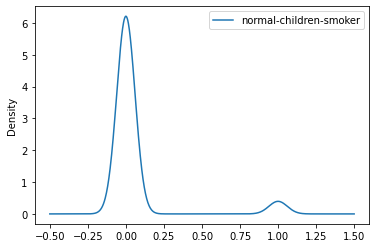

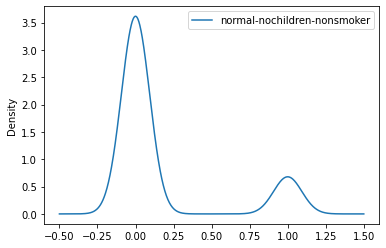

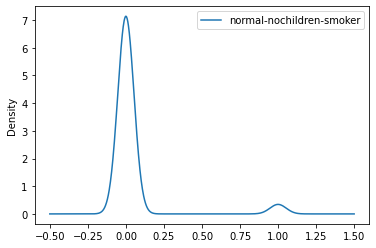

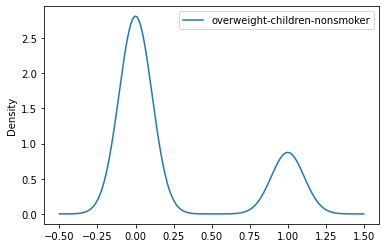

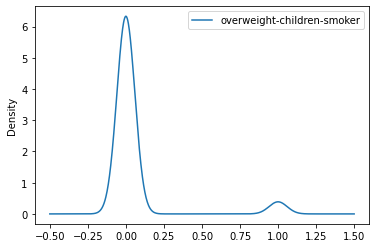

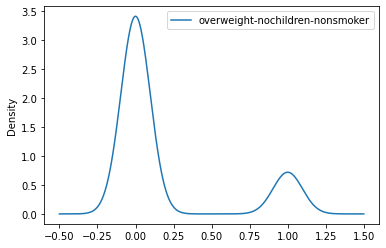

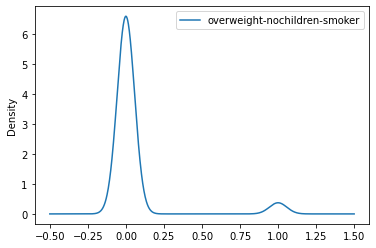

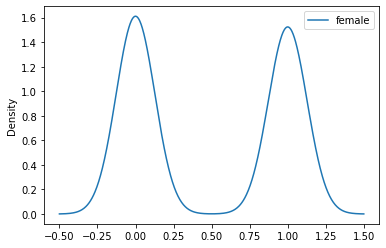

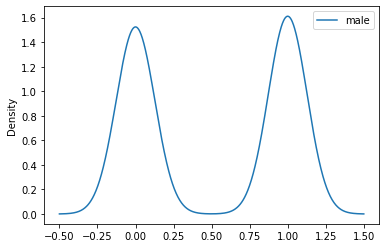

In [ ]:
for x in X.columns:
  try:
    pd.DataFrame(X[x]).plot.kde()
  except:
    pass

# Lasso Regularization. Linear regression model

Se utiliza como modelo a entrenar una regresión lineal Lasso con regularización l1 e híper-parámetro α igual a 5

In [ ]:
alfaLasso = 5 #@param {type: "slider", min: 1, max: 20, step: 1}

lasso = Lasso(alpha=alfaLasso)
lasso.fit(X, y)

Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

# Analysis results

In [ ]:
coeficientes = pd.DataFrame(data=np.expand_dims(np.concatenate((lasso.coef_, [lasso.intercept_])), axis=0), columns=np.concatenate((X.columns, ['intercept'])))
coeficientes

,age,normal-children-nonsmoker,normal-children-smoker,normal-nochildren-nonsmoker,normal-nochildren-smoker,overweight-children-nonsmoker,overweight-children-smoker,overweight-nochildren-nonsmoker,overweight-nochildren-smoker,female,male,intercept
0,3756.341735,-7485.758554,5544.153241,-9095.506725,5019.968758,-7293.677502,25684.006206,-9204.104981,24287.225692,163.309083,-3.111785e-14,16492.993533


[[ 3.75634174e+03 -7.48575855e+03  5.54415324e+03 -9.09550672e+03
   5.01996876e+03 -7.29367750e+03  2.56840062e+04 -9.20410498e+03
   2.42872257e+04  1.63309083e+02 -3.11178466e-14  1.64929935e+04]]


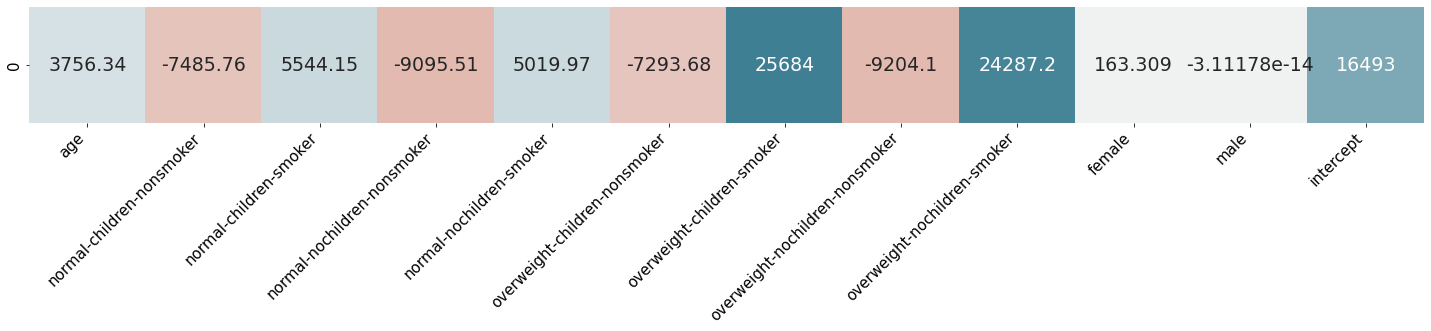

In [ ]:
def dibujarHeatMapCoeficientes(datos):
  maximo = max(abs(datos.values)[0])

  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 25))

  print(datos.values)

  sns.heatmap(
      datos,
      annot     = True,
      cbar      = False,
      annot_kws = {"size": 19},
      vmin      = -maximo,
      vmax      = maximo,
      center    = 0,
      cmap      = sns.diverging_palette(20, 220, n=200),
      square    = True,
      ax        = ax,
      fmt='g'
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation = 45,
      horizontalalignment = 'right',
  )

  ax.tick_params(labelsize = 15)

dibujarHeatMapCoeficientes(coeficientes)

Como se puede observar la mayor influencia está en las columnas provenientes de la combinación de bmi, children y smoker, aumentando mucho el valor del coste médico cuando coinciden las tres variables de forma negativa.

Por otro lado, el sexo no es significativo, sin influir nada en caso de los hombres y muy poco en el de las mujeres.

Por último la edad influye de forma mayor que el sexo, pero sin llegar a los resultados de las columnas combinadas. En el gráfico anterior solo se observa la influencia de age tras las transformaciones (elevar al cubo y estandarizar) por lo que no representa totalmente el resultado de esta columna.

Es importante decir que por defecto, por el hecho de ser persona, el valor del coste médico es de 16492,993533. El resto de columnas y sus pesos provocarán alteraciones a este valor inicial.

# Validation

Se muestran varios métodos de validación, pero para la comparativa de los resultados se ha utilizado el R2.

In [ ]:
def numpyToString(array):
  result = "["
  for el in array:
    result+=str(el)+", "
  return result[:-2]+"]"

In [ ]:
def validar(reg, X, y, cv=5):
  print("  Mean_squared_error: " + numpyToString(cross_val_score(reg, X, y, cv=cv, scoring='neg_mean_squared_error')))
  print("  Max_error: " + numpyToString(cross_val_score(reg, X, y, cv=cv, scoring='max_error')))
  print("  Median_absolute_error: " + numpyToString(cross_val_score(reg, X, y, cv=cv, scoring='neg_median_absolute_error')))
  print("  Median_absolute_error (leave one out): " + str(np.mean(cross_val_score(reg, X, y, cv=X.shape[0], scoring='neg_median_absolute_error'))))
  r2 = cross_val_score(reg, X, y, cv=cv, scoring = 'r2').mean()
  print("  R2: "+ str(r2))
  return r2

In [ ]:
print("LASSO")
scoreLasso = validar(lasso, X, y)

LASSO
  Mean_squared_error: [-19105668.128783118, -28790014.409672905, -17047137.69657024, -16848670.546408873, -25623461.649793983]
  Max_error: [-21851.36349580624, -21393.678018008395, -23061.868422564152, -21792.255237664605, -21627.81593198568]
  Median_absolute_error: [-1607.5287948321895, -1504.0631769660322, -1629.4110195102753, -1577.070605927388, -1557.0345292145498]
  Median_absolute_error (leave one out): -2610.133747347856
  R2: 0.8546054715169538



# Predictions

Se realizan las mismas transformaciones a los datos de la predicción que las hechas a los datos de entrenamiento.

In [ ]:
Xtest = pd.DataFrame(column_transformer_discreto.fit_transform(data_test), columns=columns1)
Xtest = pd.DataFrame(column_transformer_continuo.fit_transform(Xtest), columns=columns2)
Xtest

,age,normal-children-nonsmoker,normal-children-smoker,normal-nochildren-nonsmoker,normal-nochildren-smoker,overweight-children-nonsmoker,overweight-children-smoker,overweight-nochildren-nonsmoker,overweight-nochildren-smoker,female,male
0,-0.335327,1,0,0,0,0,0,0,0,1,0
1,-0.972079,0,0,0,0,0,0,1,0,0,1
2,-1.04376,0,0,1,0,0,0,0,0,0,1
3,-0.651083,0,0,0,0,0,1,0,0,0,1
4,0.452375,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
397,1.92882,0,0,0,0,0,0,1,0,1,0
398,-0.83994,0,0,0,0,0,0,1,0,0,1
399,0.265666,0,0,1,0,0,0,0,0,1,0
400,-0.949703,0,0,1,0,0,0,0,0,0,1


Se realiza la predicción.

In [ ]:
resultLasso = pd.DataFrame({'id': data_test['id'], 'charges': lasso.predict(Xtest)})
resultLasso

,id,charges
0,1319,7910.940344
1,12,3637.426290
2,487,3476.767990
3,1118,39731.307701
4,460,11061.901377
...,...,...
397,332,14697.509662
398,226,4133.785636
399,1285,8558.726798
400,631,3830.078449


# Saving generated predictions

In [ ]:
def guardar(score, prediccion, nombreModelo, ruta='/content', params=[]):
  try:
    os.mkdir(ruta)
  except:
    pass

  nombre = ruta + '/'+ str(score) + ' - '+nombreModelo
  for param in params:
    nombre += ' ' +param[0]+'='+str(param[1])

  nombre+='.csv'
  prediccion.to_csv(nombre, index=False)

In [ ]:
guardar(scoreLasso, resultLasso, 'Lasso', params = [('Alfa', alfaLasso)], ruta='predicciones')